In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Download the Gesture-Data

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
import numpy as np
import os
import imageio.v2 as imageio # Import imageio.v2 instead of scipy.misc as they are depricated in SCiPy 1.0.0
#from scipy.misc import imread, imresize
import datetime
import os
from PIL import Image, ImageFilter, ImageEnhance
import cv2  # Import OpenCV for image resizing
import matplotlib.pyplot as plt
from skimage.transform import resize as imresize
import random as rn
import tensorflow as tf
from keras import backend as K

from tensorflow.keras.regularizers import l2,l1
import math
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping # Import LearningRateScheduler and EarlyStopping

We set the random seed so that the results don't vary drastically.

In [3]:
seed_fix = 30
np.random.seed(seed_fix)
rn.seed(seed_fix)
tf.random.set_seed(seed_fix) # as per new version code

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
# This line reads the  data from file,
# shuffles the order of the lines randomly, and stores the shuffled lines in the variable.
#This is a common preprocessing step to ensure that the training data is presented to the model in a random order,
#which helps prevent bias and improves generalization.

train_doc = np.random.permutation(open('/content/drive/MyDrive/Data-For-Analysis/Gesture-Analysis/Extracted_Project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/Data-For-Analysis/Gesture-Analysis/Extracted_Project_data/Project_data/val.csv').readlines())

print("Type of train variable :", type(train_doc))
print("Type of val variable :", type(val_doc))
print("Shape of train variable :", train_doc.shape)
print("Shape of val variable :", val_doc.shape)
print("Length of train variable:", len(train_doc))
print("Length of val variable:", len(val_doc))
print("First value of train array:", train_doc[0])

print("Folder Name :", train_doc[0].split(';')[0],
      '\n Gesture :', train_doc[0].split(';')[1]
      ,"\n Label :", train_doc[0].split(';')[2])

print("First value of val array:", val_doc[0])

print("Folder Name :", val_doc[0].split(';')[0],
      '\n Gesture :', val_doc[0].split(';')[1]
      ,"\n Label :", val_doc[0].split(';')[2])

#print(train_doc)
#print(val_doc)

Type of train variable : <class 'numpy.ndarray'>
Type of val variable : <class 'numpy.ndarray'>
Shape of train variable : (663,)
Shape of val variable : (100,)
Length of train variable: 663
Length of val variable: 100
First value of train array: WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1

Folder Name : WIN_20180926_16_54_08_Pro_Right_Swipe_new 
 Gesture : Right_Swipe_new 
 Label : 1

First value of val array: WIN_20180926_17_24_20_Pro_Thumbs_Down_new;Thumbs_Down_new;3

Folder Name : WIN_20180926_17_24_20_Pro_Thumbs_Down_new 
 Gesture : Thumbs_Down_new 
 Label : 3



In [5]:
# Get the # of image count in each folder of train and val if it's not equal to 58
img_train_count = {}
img_val_count = {}

for row in train_doc:
  folder_name = row.split(';')[0]
  folder_path = os.path.join('/content/drive/MyDrive/Data-For-Analysis/Gesture-Analysis/Extracted_Project_data/Project_data/train', folder_name)
  image_count = len(os.listdir(folder_path))
  img_train_count[folder_name] = image_count

for row in val_doc:
  folder_name = row.split(';')[0]
  folder_path = os.path.join('/content/drive/MyDrive/Data-For-Analysis/Gesture-Analysis/Extracted_Project_data/Project_data/val', folder_name)
  image_count = len(os.listdir(folder_path))
  img_val_count[folder_name] = image_count

# print size of train and val
print("Size of train:", len(img_train_count))
print("Size of val:", len(img_val_count))

# print distinct image counts from train and val
print("Distinct image counts in train:", set(img_train_count.values()))
print("Distinct image counts in val:", set(img_val_count.values()))

Size of train: 663
Size of val: 100
Distinct image counts in train: {30}
Distinct image counts in val: {30}


In [6]:
# Setting constants
batch_size = 16 # experiment with the batch size

#list of indices that specify which frames/images within each video folder should be loaded.
img_idx = range(1,29,2)

# image dimensions
img_x, img_y = 180, 180
img_channel = 3
image_size = (img_x, img_y)


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

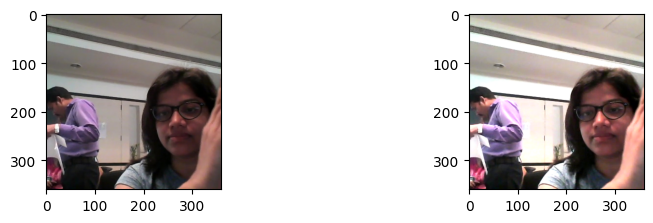

In [7]:
image = imageio.imread('/content/drive/MyDrive/Data-For-Analysis/Gesture-Analysis/Extracted_Project_data/Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png').astype(np.float32)
image_pil = Image.fromarray(image.astype('uint8'))

image_augm = np.array(ImageEnhance.Brightness((image_pil)).enhance(1.5))
plt.figure(figsize=(10, 5))
plt.subplot(2, 2,1)
plt.imshow(image.astype('uint8'))
plt.subplot(2, 2,2)
plt.imshow(image_augm.astype('uint8'))

In [8]:
def generator(source_path, folder_list, batch_size, img_idx, image_size=(80, 80), is_train=False, augm=False, debug=False):

    if debug:
        print('Source path = ', source_path, '; batch size =', batch_size)
        print("Length of original folder list", len(folder_list))
        print("# of images to be loaded:", len(img_idx))
        print("Image size:", image_size)
        print("Is train:", is_train)
        print("Augmentation:", augm)
        print("Debug:", debug)

    num_frame_vid = len(img_idx)
    img_c = 3

    while True:

        if is_train and augm:
            random_fold_list = np.concatenate((np.random.permutation(folder_list), np.random.permutation(folder_list)))
        else:
            random_fold_list = np.random.permutation(folder_list)

        num_batches = (len(random_fold_list) + batch_size - 1) // batch_size

        if debug:
            print("Length of augmented folder list", len(random_fold_list))
            print("Number of batches", num_batches)



        for batch in range(num_batches):

            if debug:
                print("Batch number equal to :", batch)

            batch_data = np.zeros((batch_size, num_frame_vid, image_size[0], image_size[1], img_c))
            batch_labels = np.zeros((batch_size, 5))

            start_index = batch * batch_size
            end_index = min((batch + 1) * batch_size, len(random_fold_list))
            range_size = end_index - start_index

            for folder_index in range(range_size):

                folder = start_index + folder_index

                if debug:
                  print("folder Index:",folder_index)
                  print("folder number equal to :", folder)

                aug_type = None
                if is_train and augm and rn.randint(0, 1) == 1:
                  aug_type = rn.randint(0, 4)


                imgs = os.listdir(source_path + '/' + random_fold_list[folder].split(';')[0])

                if debug:
                  print("Aug Type is :", aug_type)
                  print("random_fold_list[folder]", random_fold_list[folder])
                  print("random_fold_list[folder].strip().split(';')[0]: ", random_fold_list[folder].strip().split(';')[0])
                  print("random_fold_list[folder].strip().split(';')[1]: ", random_fold_list[folder].strip().split(';')[1])
                  print("random_fold_list[folder].strip().split(';')[2]: ", random_fold_list[folder].strip().split(';')[2])
                  print("imgs: ", imgs)

                if not imgs:
                    print(f"Warning: Empty folder found: {source_path + '/' + random_fold_list[folder].split(';')[0]}")
                    for idx in range(num_frame_vid):
                        batch_data[folder_index, idx, :, :, :] = np.zeros((image_size[0], image_size[1], 3), dtype=np.float32)
                        batch_labels[folder_index, int(random_fold_list[folder].strip().split(';')[2])] = 1
                    continue

                for idx, item in enumerate(img_idx):
                    try:
                        image = imageio.imread(source_path + '/' + random_fold_list[folder].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)
                    except IndexError:
                        print(f"IndexError: {source_path + '/' + random_fold_list[folder].strip().split(';')[0] + '/' + imgs[item]}")
                        image = np.zeros((image_size[0], image_size[1], 3), dtype=np.float32)

                    if debug:
                        print("\n After reading image, item#:", item)
                        print("image shape", image.shape)

                        plt.subplot(3, len(img_idx), idx + 1)
                        plt.imshow(image.astype('uint8'))
                    # Initialize image_augm to the original image
                    image_augm = image
                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px // 2
                        crop_end = crop_start + image.shape[0]
                        image_augm = image[:, crop_start:crop_end]
                        if debug:
                          print("Inside image.shape[1] > image.shape[0]:")
                          print("diff_px: ",diff_px)
                          print("crop_start: ",crop_start)
                          print("crop_end: ",crop_end)
                          print("image.shape: ",image_augm.shape)
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px // 2
                        crop_end = crop_start + image.shape[1]
                        image_augm = image[crop_start:crop_end, :]
                        if debug:
                          print("Inside image.shape[0] > image.shape[1]")
                          print("diff_px: ",diff_px)
                          print("crop_start: ",crop_start)
                          print("crop_end: ",crop_end)
                          print("image.shape: ",image_augm.shape)

                    image_resized = cv2.resize(image_augm, image_size)

                    if debug:
                        print("After resize")
                        print("image size ",image_resized.shape)
                        plt.subplot(3, len(img_idx), idx + len(img_idx) + 1)
                        plt.imshow(image_resized.astype('uint8'))


                    image_pil = Image.fromarray(image_resized.astype('uint8'))

                    if aug_type is not None:
                        if aug_type == 0:
                          if debug:
                            print("Inside EDGE_ENHANCE")
                          image_augm = np.array(image_pil.filter(ImageFilter.EDGE_ENHANCE))
                        elif aug_type == 1:
                          if debug:
                            print("Inside GaussianBlur(1)")
                          image_augm = np.array(image_pil.filter(ImageFilter.GaussianBlur(1)))
                        elif aug_type == 2:
                          if debug:
                            print("Inside DETAIL")
                          image_augm = np.array(image_pil.filter(ImageFilter.DETAIL))
                        elif aug_type == 3:
                          if debug:
                            print("Inside SHARPEN")
                          image_augm = np.array(image_pil.filter(ImageFilter.SHARPEN))
                        elif aug_type == 4:
                          if debug:
                            print("Inside Brightness")
                          image_augm = np.array(ImageEnhance.Brightness(image_pil).enhance(1.5))
                    else:
                      if debug:
                        print("Inside else")
                      image_augm = np.array(image_pil)

                    if debug:
                        print("After resizing and augmented")
                        plt.subplot(3, len(img_idx), idx + 2*len(img_idx) + 1)
                        plt.imshow(image_augm.astype('uint8'))

                    image_augm_norm = image_augm.astype(np.float32) / 255.0

                    batch_data[folder_index, idx, :, :, 0] = image_augm_norm[:, :, 0]
                    batch_data[folder_index, idx, :, :, 1] = image_augm_norm[:, :, 1]
                    batch_data[folder_index, idx, :, :, 2] = image_augm_norm[:, :, 2]

                label_index = int(random_fold_list[folder].strip().split(';')[2])
                batch_labels[folder_index, label_index] = 1

                if debug :
                  print(f"Folder_index: {folder_index}, Label Index: {label_index}")
                  print(f"Batch Labels: {batch_labels[folder_index]}")

            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Data-For-Analysis/Gesture-Analysis/Extracted_Project_data/Project_data/train'
val_path = '/content/drive/MyDrive/Data-For-Analysis/Gesture-Analysis/Extracted_Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


Source path =  /content/drive/MyDrive/Data-For-Analysis/Gesture-Analysis/Extracted_Project_data/Project_data/train ; batch size = 1
Length of original folder list 663
# of images to be loaded: 14
Image size: (180, 180)
Is train: True
Augmentation: True
Debug: True
Length of augmented folder list 1326
Number of batches 1326
Batch number equal to : 0
folder Index: 0
folder number equal to : 0
Aug Type is : 4
random_fold_list[folder] WIN_20180926_17_24_58_Pro_Right_Swipe_new;Right_Swipe_new;1

random_fold_list[folder].strip().split(';')[0]:  WIN_20180926_17_24_58_Pro_Right_Swipe_new
random_fold_list[folder].strip().split(';')[1]:  Right_Swipe_new
random_fold_list[folder].strip().split(';')[2]:  1
imgs:  ['WIN_20180926_17_24_58_Pro_00007.png', 'WIN_20180926_17_24_58_Pro_00009.png', 'WIN_20180926_17_24_58_Pro_00011.png', 'WIN_20180926_17_24_58_Pro_00013.png', 'WIN_20180926_17_24_58_Pro_00015.png', 'WIN_20180926_17_24_58_Pro_00017.png', 'WIN_20180926_17_24_58_Pro_00019.png', 'WIN_20180926_17

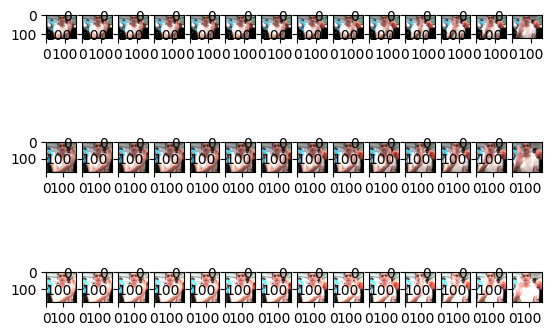

In [10]:
# testing generative
#test_gen = generator_new(train_path, train_doc, 1, img_idx, is_train = True, augmention = True, debug = True)
test_gen = generator(train_path, train_doc, 1, img_idx, image_size, is_train = True, augm = True, debug = True)
d = next(test_gen)[0]

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten,Input, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv3D, Conv2D,ConvLSTM2D, MaxPooling3D, AveragePooling3D,GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from tensorflow.keras import layers
import tensorflow as tf

# Enable eager execution
tf.compat.v1.enable_eager_execution(True)

In [12]:
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam,Adadelta,SGD  # or any other optimizer

# Choose HyperParameters
## Hyperparameters
le_rate = 0.001
optimizer = Adam(learning_rate=le_rate)
#optimizer=optimizer=RMSprop(learning_rate=le_rate)
#optimizer=Nadam(learning_rate=le_rate)
#optimizer=Adadelta(learning_rate=le_rate)
#optimizer = SGD(learning_rate=le_rate, momentum=0.9)

input_shape=(len(img_idx),img_x,img_y,img_channel)
print("Input_shape :",input_shape)
# Initialize the model
init_weight     = 'normal'    # Initial weight for initializations
activation_func = 'relu'
out_acti_func   = 'softmax'
loss_fn         = "categorical_crossentropy"
accuracy        = ['categorical_accuracy']

enable_augmentation = False # augmentation of Data

Input_shape : (14, 180, 180, 3)


In [13]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
    print("steps_per_epoch",steps_per_epoch)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1
    print("steps_per_epoch when we have reminder",steps_per_epoch)

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
    print("validation_steps",validation_steps)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    print("validation_steps when we have reminder",validation_steps)

steps_per_epoch when we have reminder 42
validation_steps when we have reminder 7


##Experiment with first model
Image Input of size : 120 X 120
* First layer, a 3D convolutional layer of depth 32 and Kernal_size (3 X 3 X 3)
* 2nd layer, a 3D max pooling layer with pool size of 1,2,2
* 3rd layer, a 3D convolutional layer of depth 32 and Kernal_size (3 X 3 X 3)
* 4th layer, a 3D max pooling layer with pool size of 1,2,2
* 5th layer, a flatten This layer flattens the multi-dimensional output of the previous layer into a 1D vector.
* 6th layer, A fully connected (dense) layer with 256 neurons.
* 7th layer, final/output dense layer with 5 neurons, corresponding to the 5 classes in your classification task.

In [ ]:
'''

#Model Name Generation and Directory Creation:
model_name = 'model_init'+'1st Model' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
print("modal_name:", model_name)
#write your model here
model = Sequential()

model.add(Conv3D(32, kernel_size=(3, 3, 3), activation=activation_func, input_shape=input_shape,padding='same'))
model.add(MaxPooling3D(pool_size=(1,2,2)))

model.add(Conv3D(64, kernel_size=(3, 3, 3), activation=activation_func,padding='same'))
model.add(MaxPooling3D(pool_size=(1,2,2)))

model.add(Flatten())
model.add(Dense(256, activation=activation_func))
model.add(Dense(5, activation=out_acti_func ))
'''

'\n\n#Model Name Generation and Directory Creation:\nmodel_name = \'model_init\'+\'1st Model\' + \'_\' + str(curr_dt_time).replace(\' \',\'\').replace(\':\',\'_\') + \'/\'\nprint("modal_name:", model_name)\n#write your model here\nmodel = Sequential()\n\nmodel.add(Conv3D(32, kernel_size=(3, 3, 3), activation=activation_func, input_shape=input_shape,padding=\'same\'))\nmodel.add(MaxPooling3D(pool_size=(1,2,2)))\n\nmodel.add(Conv3D(64, kernel_size=(3, 3, 3), activation=activation_func,padding=\'same\'))\nmodel.add(MaxPooling3D(pool_size=(1,2,2)))\n\nmodel.add(Flatten())\nmodel.add(Dense(256, activation=activation_func))\nmodel.add(Dense(5, activation=out_acti_func ))\n'

### 2nd Model with Data aumentation

In [ ]:
'''

#Model Name Generation and Directory Creation:
model_name = 'model_init'+'2nd Model' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
print("modal_name:", model_name)
#write your model here
model = Sequential()

model.add(Conv3D(32, kernel_size=(3, 3, 3), activation=activation_func, input_shape=input_shape,padding='same'))
model.add(MaxPooling3D(pool_size=(1,2,2)))

model.add(Conv3D(64, kernel_size=(3, 3, 3), activation=activation_func,padding='same'))
model.add(MaxPooling3D(pool_size=(1,2,2)))

model.add(Flatten())
model.add(Dense(256, activation=activation_func))
model.add(Dense(5, activation=out_acti_func ))
'''

'\n\n#Model Name Generation and Directory Creation:\nmodel_name = \'model_init\'+\'2nd Model\' + \'_\' + str(curr_dt_time).replace(\' \',\'\').replace(\':\',\'_\') + \'/\'\nprint("modal_name:", model_name)\n#write your model here\nmodel = Sequential()\n\nmodel.add(Conv3D(32, kernel_size=(3, 3, 3), activation=activation_func, input_shape=input_shape,padding=\'same\'))\nmodel.add(MaxPooling3D(pool_size=(1,2,2)))\n\nmodel.add(Conv3D(64, kernel_size=(3, 3, 3), activation=activation_func,padding=\'same\'))\nmodel.add(MaxPooling3D(pool_size=(1,2,2)))\n\nmodel.add(Flatten())\nmodel.add(Dense(256, activation=activation_func))\nmodel.add(Dense(5, activation=out_acti_func ))\n'

### 3rd Model Changing size of image by 224 X224 by 3

In [ ]:
'''

#Model Name Generation and Directory Creation:
model_name = 'model_init'+'3rd Model' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
print("modal_name:", model_name)
#write your model here
model = Sequential()

model.add(Conv3D(32, kernel_size=(3, 3, 3), activation=activation_func, input_shape=input_shape,padding='same'))
model.add(MaxPooling3D(pool_size=(1,2,2)))

model.add(Conv3D(64, kernel_size=(3, 3, 3), activation=activation_func,padding='same'))
model.add(MaxPooling3D(pool_size=(1,2,2)))

model.add(Flatten())
model.add(Dense(256, activation=activation_func))
model.add(Dense(5, activation=out_acti_func ))
'''


modal_name: model_init3rd Model_2025-03-0405_04_23.649902/


### 4th Model adding drop out
Batch size 224 X 224 giving error hence reduced to 180 X 180

In [ ]:
'''
#Model Name Generation and Directory Creation:
model_name = 'model_init'+'4th Model' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
print("modal_name:", model_name)
#write your model here
model = Sequential()

model.add(Conv3D(32, kernel_size=(3, 3, 3), activation=activation_func, input_shape=input_shape,padding='same'))
model.add(MaxPooling3D(pool_size=(1,2,2)))
model.add(Dropout(0.2))

model.add(Conv3D(64, kernel_size=(3, 3, 3), activation=activation_func,padding='same'))
model.add(MaxPooling3D(pool_size=(1,2,2)))
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=(3, 3, 3), activation=activation_func,padding='same'))
model.add(MaxPooling3D(pool_size=(1,2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation=activation_func))
model.add(Dense(5, activation=out_acti_func ))

'''

modal_name: model_init4th Model_2025-03-0408_56_43.172580/


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 5th Model adding regularization and normalization

In [ ]:
'''


#Model Name Generation and Directory Creation:
model_name = 'model_init'+'5th Model' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
print("modal_name:", model_name)
#write your model here
model = Sequential()

model.add(Conv3D(16, kernel_size=(3, 3, 3), activation=activation_func, input_shape=input_shape,padding='same',kernel_regularizer=l2(0.01)))
#model.add(Conv3D(16, kernel_size=(3, 3, 3), activation=activation_func, input_shape=input_shape,padding='same'))
model.add(MaxPooling3D(pool_size=(1,2,2)))
#model.add(Dropout(0.2))

model.add(Conv3D(32, kernel_size=(3, 3, 3), activation=activation_func,padding='same'))
model.add(MaxPooling3D(pool_size=(1,2,2)))
#model.add(Dropout(0.2))


model.add(Conv3D(32, kernel_size=(3, 3, 3), activation=activation_func,padding='same',kernel_regularizer=l2(0.01)))
model.add(MaxPooling3D(pool_size=(1,2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64, activation=activation_func,kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dense(5, activation=out_acti_func ))
'''

modal_name: model_init5th Model_2025-03-0409_19_28.599612/


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 6th Model

In [ ]:
'''
#Model Name Generation and Directory Creation:
model_name = 'model_6th'+'6th Model' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
print("modal_name:", model_name)
model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation=activation_func,padding='same'), input_shape=input_shape)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation=activation_func))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation=activation_func))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation=activation_func))
model.add(Dense(5, activation=out_acti_func ))
'''


modal_name: model_6th6th Model_2025-03-0412_47_54.898618/


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

## Final Model
ConvLSTM Architecture: We'll retain the ConvLSTM architecture as it's designed for spatio-temporal data, but we'll refine it.
Regularization: Strong regularization using Dropout and L2 regularization.
Batch Normalization: Consistent use of Batch Normalization.
Learning Rate Scheduling: Cosine annealing for dynamic learning rate.
Early Stopping: To prevent overfitting.
Data Pipeline Optimization: (You'll need to address the tf.data warning.)
Data Augmentation: Diverse augmentations, including temporal ones.
Model Saving: Using the .keras format.


In [14]:
# --- Model Creation ---
curr_dt_time = datetime.datetime.now()
model_name = 'final_model_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '.keras'
print("model_name:", model_name)
print("Input_shape :", input_shape)

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3), activation=activation_func, padding='same', kernel_regularizer=l2(0.003)), input_shape=input_shape)) # Adjusted L2
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(32, (3, 3), activation=activation_func, kernel_regularizer=l2(0.003)))) # Adjusted L2
model.add(BatchNormalization())
model.add(ConvLSTM2D(32, kernel_size=3, return_sequences=False, kernel_regularizer=l2(0.003))) # Adjusted L2
model.add(BatchNormalization())
model.add(Dropout(0.6))  # Adjusted Dropout

model.add(Dense(128, activation=activation_func, kernel_regularizer=l2(0.003))) # Adjusted L2
model.add(BatchNormalization())
model.add(Dropout(0.6)) # Adjusted Dropout

model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation=activation_func, kernel_regularizer=l2(0.003))) # Adjusted L2
model.add(Dense(5, activation=out_acti_func))



model_name: final_model_2025-03-0504_09_18.130630.keras
Input_shape : (14, 180, 180, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
tf.config.run_functions_eagerly(True)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 14, 180, 180, 16)    │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 180, 180, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 14, 178, 178, 32)    │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 178, 178, 32)    │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d (ConvLSTM2D)             │ (None, 176, 176, 32)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 176, 176, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 176, 176, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 176, 176, 128)       │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 176, 176, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 176, 176, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,581 (361.64 KB)

 Trainable params: 92,165 (360.02 KB)

 Non-trainable params: 416 (1.62 KB)

None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [16]:
print("train_path",train_path)
print("val_path",val_path)
print("batch_size :",batch_size)
print("Image_size",image_size)

enable_augmentation = True
train_generator = generator(train_path, train_doc, batch_size, img_idx, image_size, is_train = True, augm = enable_augmentation, debug = False)
val_generator   = generator(val_path, val_doc, batch_size, img_idx,image_size,debug = False)

train_path /content/drive/MyDrive/Data-For-Analysis/Gesture-Analysis/Extracted_Project_data/Project_data/train
val_path /content/drive/MyDrive/Data-For-Analysis/Gesture-Analysis/Extracted_Project_data/Project_data/val
batch_size : 16
Image_size (180, 180)


In [19]:
#Model Directory Creation for saving epochs:

#If directory don't exist create a new directory
if not os.path.exists(model_name):
    os.mkdir(model_name)
google_drive_path = '/content/drive/MyDrive/Data-For-Analysis/Gesture-Analysis/File_upload/'
#This line creates a file path for saving model checkpoints.
#{epoch:05d}: The epoch number (padded with leading zeros to 5 digits).
#{categorical_accuracy:.5f}: The training categorical accuracy (formatted to 5 decimal places).
filepath = google_drive_path+model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
print("filepath:",filepath)
#ModelCheckpoint Callback:is used to save the model's weights during training
#monitor='val_loss': This tells the callback to monitor the validation loss.

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

#This creates a ReduceLROnPlateau callback, which is used to reduce the learning rate when the validation loss stops improving.
#monitor='val_loss': Monitors the validation loss.
#factor=0.2: Reduces the learning rate by a factor of 0.2 when triggered.
#patience=5: The number of epochs with no improvement after which the learning rate will be reduced.
#min_lr=0.001: The minimum learning rate allowed.

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.0002, patience=2, min_lr=0.00001, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

filepath: /content/drive/MyDrive/Data-For-Analysis/Gesture-Analysis/File_upload/final_model_2025-03-0504_09_18.130630.kerasmodel-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5


In [20]:
# --- Learning Rate Scheduler (Cosine Annealing) ---
learning_rate = 0.0005  #  can adjust this value
def cosine_annealing(epoch, lr):
    epochs_total = num_epochs
    lr_min = 0
    lr_max = learning_rate
    return lr_min + (lr_max - lr_min) * (1 + math.cos(math.pi * epoch / epochs_total)) / 2

lr_scheduler = LearningRateScheduler(cosine_annealing)

# --- Early Stopping ---
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
callbacks_final = [checkpoint, lr_scheduler, early_stopping]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
'''
#1st Model Output
num_epochs = 10 # choose the number of epochs
init_epoch=0
# print optimizer used
print("1st Model Output")
print("Optimizer used is :", optimizer)
print("enable_augmentation :", enable_augmentation)
# fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
          callbacks=callbacks_list, validation_data=val_generator,
          validation_steps=validation_steps, class_weight=None, initial_epoch=init_epoch)
'''

1st Model Output
Optimizer used is : <keras.src.optimizers.adam.Adam object at 0x7fd2d97d73d0>
enable_augmentation : False
Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 256s/step - categorical_accuracy: 0.2082 - loss: 24.3532  
Epoch 1: saving model to model_init1st Model_2025-03-0314_14_59.752115/model-00001-11.43817-0.20536-1.25167-0.18750.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6026s 300s/step - categorical_accuracy: 0.2080 - loss: 23.7661 - val_categorical_accuracy: 0.1875 - val_loss: 1.2517 - learning_rate: 0.0010
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3745 - loss: 1.5833
Epoch 2: saving model to model_init1st Model_2025-03-0314_14_59.752115/model-00002-1.52721-0.31399-1.01118-0.32812.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - categorical_accuracy: 0.3717 - loss: 1.5807 - val_categorical_accuracy: 0.3281 - val_loss: 1.0112 - learning_rate: 0.0010
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5511 - loss: 1.1126
Epoch 3: saving model to model_init1st Model_2025-03-0314_14_59.752115/model-00003-0.95699-0.61756-0.82842-0.50000.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - categorical_accuracy: 0.5541 - loss: 1.1055 - val_categorical_accuracy: 0.5000 - val_loss: 0.8284 - learning_rate: 0.0010
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8597 - loss: 0.3615
Epoch 4: saving model to model_init1st Model_2025-03-0314_14_59.752115/model-00004-0.37545-0.85119-0.63272-0.53906.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - categorical_accuracy: 0.8593 - loss: 0.3621 - val_categorical_accuracy: 0.5391 - val_loss: 0.6327 - learning_rate: 0.0010
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9460 - loss: 0.1752
Epoch 5: saving model to model_init1st Model_2025-03-0314_14_59.752115/model-00005-0.16166-0.94345-0.56419-0.57812.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - categorical_accuracy: 0.9459 - loss: 0.1746 - val_categorical_accuracy: 0.5781 - val_loss: 0.5642 - learning_rate: 0.0010
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9815 - loss: 0.0970
Epoch 6: saving model to model_init1st Model_2025-03-0314_14_59.752115/model-00006-0.07351-0.97024-0.86708-0.58594.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - categorical_accuracy: 0.9809 - loss: 0.0959 - val_categorical_accuracy: 0.5859 - val_loss: 0.8671 - learning_rate: 0.0010
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9916 - loss: 0.0253
Epoch 7: saving model to model_init1st Model_2025-03-0314_14_59.752115/model-00007-0.04534-0.98512-0.87701-0.53125.h5



Epoch 7: ReduceLROnPlateau reducing learning rate to 1e-05.
21/21 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - categorical_accuracy: 0.9913 - loss: 0.0262 - val_categorical_accuracy: 0.5312 - val_loss: 0.8770 - learning_rate: 0.0010
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9928 - loss: 0.0377
Epoch 8: saving model to model_init1st Model_2025-03-0314_14_59.752115/model-00008-0.03873-0.97768-0.97286-0.50781.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - categorical_accuracy: 0.9921 - loss: 0.0378 - val_categorical_accuracy: 0.5078 - val_loss: 0.9729 - learning_rate: 1.0000e-05
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9938 - loss: 0.0341
Epoch 9: saving model to model_init1st Model_2025-03-0314_14_59.752115/model-00009-0.03116-0.98065-0.93353-0.53125.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - categorical_accuracy: 0.9932 - loss: 0.0340 - val_categorical_accuracy: 0.5312 - val_loss: 0.9335 - learning_rate: 1.0000e-05
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9953 - loss: 0.0217
Epoch 10: saving model to model_init1st Model_2025-03-0314_14_59.752115/model-00010-0.02519-0.98214-0.83107-0.55469.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - categorical_accuracy: 0.9947 - loss: 0.0219 - val_categorical_accuracy: 0.5547 - val_loss: 0.8311 - learning_rate: 1.0000e-05


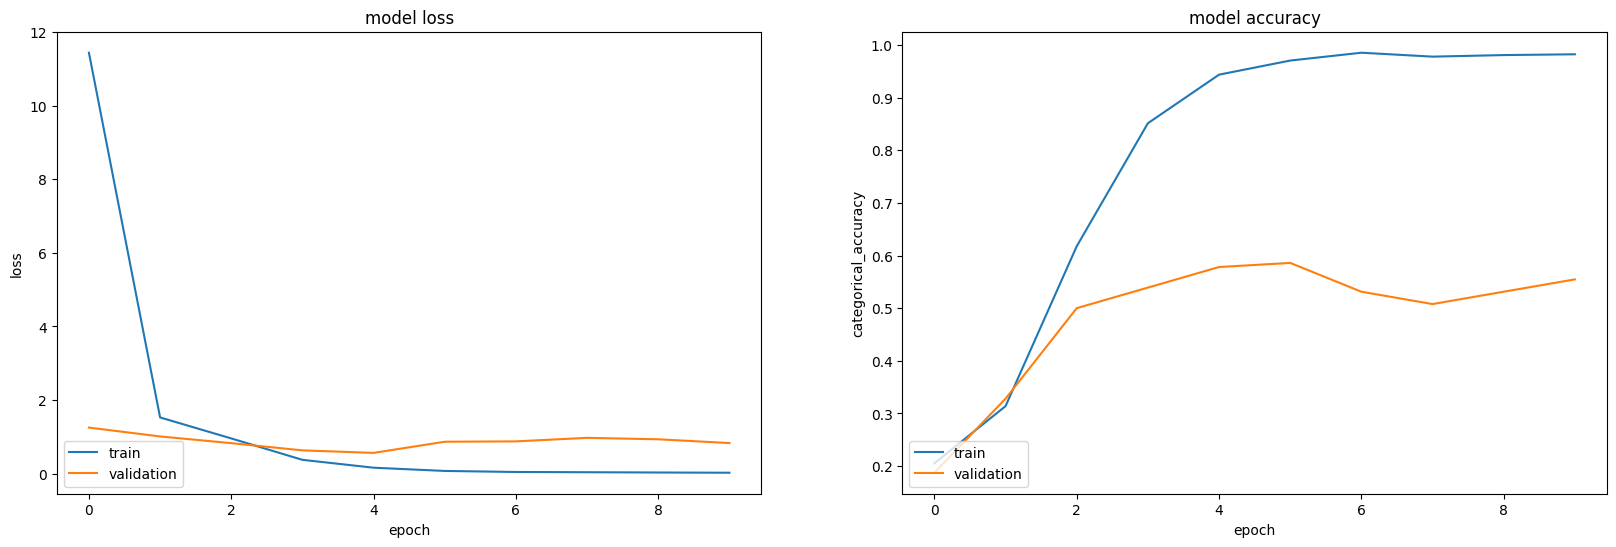

In [ ]:
'''
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
'''

### Outcome analysis


In [ ]:
'''
# 2nd Model fit and output
num_epochs = 10 # choose the number of epochs
init_epoch=0
# print optimizer used
print("2nd Model Output")
print("Optimizer used is :", optimizer)
print("enable_augmentation :", enable_augmentation)
# fit the model
history= model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
          callbacks=callbacks_list, validation_data=val_generator,
          validation_steps=validation_steps, class_weight=None, initial_epoch=init_epoch)
'''

2nd Model Output
Optimizer used is : <keras.src.optimizers.adam.Adam object at 0x77fd05acf710>
enable_augmentation : True
Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 311s/step - categorical_accuracy: 0.2280 - loss: 19.9749  
Epoch 1: saving model to model_init2nd Model_2025-03-0401_56_31.142563/model-00001-9.16233-0.27083-1.02236-0.39062.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 7259s 362s/step - categorical_accuracy: 0.2299 - loss: 19.4835 - val_categorical_accuracy: 0.3906 - val_loss: 1.0224 - learning_rate: 0.0010
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6025 - loss: 1.0585
Epoch 2: saving model to model_init2nd Model_2025-03-0401_56_31.142563/model-00002-0.94549-0.62202-0.86991-0.68750.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - categorical_accuracy: 0.6034 - loss: 1.0534 - val_categorical_accuracy: 0.6875 - val_loss: 0.8699 - learning_rate: 0.0010
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8264 - loss: 0.5895
Epoch 3: saving model to model_init2nd Model_2025-03-0401_56_31.142563/model-00003-0.49037-0.84226-0.87905-0.50781.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - categorical_accuracy: 0.8271 - loss: 0.5850 - val_categorical_accuracy: 0.5078 - val_loss: 0.8790 - learning_rate: 0.0010
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9430 - loss: 0.2265
Epoch 4: saving model to model_init2nd Model_2025-03-0401_56_31.142563/model-00004-0.19912-0.91815-0.92648-0.52344.h5



Epoch 4: ReduceLROnPlateau reducing learning rate to 1e-05.
21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - categorical_accuracy: 0.9419 - loss: 0.2252 - val_categorical_accuracy: 0.5234 - val_loss: 0.9265 - learning_rate: 0.0010
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9775 - loss: 0.0886
Epoch 5: saving model to model_init2nd Model_2025-03-0401_56_31.142563/model-00005-0.07934-0.98065-0.79467-0.55469.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - categorical_accuracy: 0.9776 - loss: 0.0882 - val_categorical_accuracy: 0.5547 - val_loss: 0.7947 - learning_rate: 1.0000e-05
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9712 - loss: 0.0876
Epoch 6: saving model to model_init2nd Model_2025-03-0401_56_31.142563/model-00006-0.07141-0.95685-0.79630-0.56250.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - categorical_accuracy: 0.9705 - loss: 0.0869 - val_categorical_accuracy: 0.5625 - val_loss: 0.7963 - learning_rate: 1.0000e-05
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9809 - loss: 0.0732
Epoch 7: saving model to model_init2nd Model_2025-03-0401_56_31.142563/model-00007-0.06756-0.98958-0.90534-0.57031.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - categorical_accuracy: 0.9813 - loss: 0.0729 - val_categorical_accuracy: 0.5703 - val_loss: 0.9053 - learning_rate: 1.0000e-05
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9904 - loss: 0.0609
Epoch 8: saving model to model_init2nd Model_2025-03-0401_56_31.142563/model-00008-0.05779-0.96429-0.87031-0.54688.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - categorical_accuracy: 0.9892 - loss: 0.0607 - val_categorical_accuracy: 0.5469 - val_loss: 0.8703 - learning_rate: 1.0000e-05
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9883 - loss: 0.0569
Epoch 9: saving model to model_init2nd Model_2025-03-0401_56_31.142563/model-00009-0.05995-0.98810-0.90703-0.54688.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - categorical_accuracy: 0.9883 - loss: 0.0571 - val_categorical_accuracy: 0.5469 - val_loss: 0.9070 - learning_rate: 1.0000e-05
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9912 - loss: 0.0538
Epoch 10: saving model to model_init2nd Model_2025-03-0401_56_31.142563/model-00010-0.05655-0.96577-0.90325-0.53125.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - categorical_accuracy: 0.9901 - loss: 0.0539 - val_categorical_accuracy: 0.5312 - val_loss: 0.9033 - learning_rate: 1.0000e-05


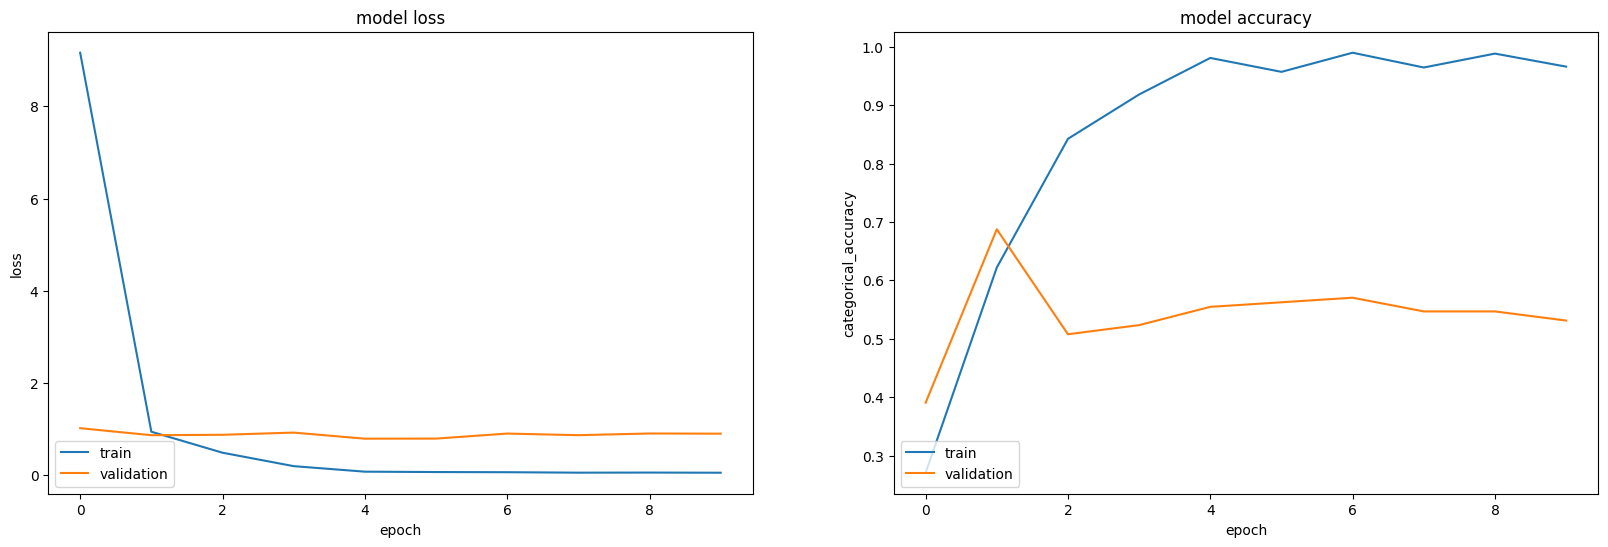

In [ ]:
'''
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
'''

In [ ]:
'''
#3rd Model Output
num_epochs = 10 # choose the number of epochs
init_epoch=0
# print optimizer used
print("3rd Model Output")
print("Optimizer used is :", optimizer)
print("enable_augmentation :", enable_augmentation)
print("Image_size:", image_size)
# fit the model
history= model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
          callbacks=callbacks_list, validation_data=val_generator,
          validation_steps=validation_steps, class_weight=None, initial_epoch=init_epoch)
'''

3rd Model Output
Optimizer used is : <keras.src.optimizers.adam.Adam object at 0x7d6473f40b10>
enable_augmentation : True
Image_size: (224, 224)
Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 315s/step - categorical_accuracy: 0.1949 - loss: 87.6166  
Epoch 1: saving model to model_init3rd Model_2025-03-0405_04_23.649902/model-00001-37.86732-0.19345-1.25696-0.17188.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 7405s 369s/step - categorical_accuracy: 0.1949 - loss: 85.3552 - val_categorical_accuracy: 0.1719 - val_loss: 1.2570 - learning_rate: 0.0010
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.1878 - loss: 1.6060
Epoch 2: saving model to model_init3rd Model_2025-03-0405_04_23.649902/model-00002-1.55679-0.22321-1.19927-0.37500.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 95s 5s/step - categorical_accuracy: 0.1894 - loss: 1.6038 - val_categorical_accuracy: 0.3750 - val_loss: 1.1993 - learning_rate: 0.0010
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4363 - loss: 1.5416
Epoch 3: saving model to model_init3rd Model_2025-03-0405_04_23.649902/model-00003-1.54295-0.41964-1.17887-0.55469.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 94s 5s/step - categorical_accuracy: 0.4356 - loss: 1.5417 - val_categorical_accuracy: 0.5547 - val_loss: 1.1789 - learning_rate: 0.0010
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4679 - loss: 1.3895
Epoch 4: saving model to model_init3rd Model_2025-03-0405_04_23.649902/model-00004-1.30970-0.45982-0.97315-0.59375.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step - categorical_accuracy: 0.4675 - loss: 1.3859 - val_categorical_accuracy: 0.5938 - val_loss: 0.9732 - learning_rate: 0.0010
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6108 - loss: 0.9394
Epoch 5: saving model to model_init3rd Model_2025-03-0405_04_23.649902/model-00005-0.86317-0.63988-0.98664-0.48438.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step - categorical_accuracy: 0.6121 - loss: 0.9360 - val_categorical_accuracy: 0.4844 - val_loss: 0.9866 - learning_rate: 0.0010
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9116 - loss: 0.3457
Epoch 6: saving model to model_init3rd Model_2025-03-0405_04_23.649902/model-00006-0.36068-0.88690-0.89085-0.52344.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - categorical_accuracy: 0.9104 - loss: 0.3464 - val_categorical_accuracy: 0.5234 - val_loss: 0.8909 - learning_rate: 0.0010
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9629 - loss: 0.1319
Epoch 7: saving model to model_init3rd Model_2025-03-0405_04_23.649902/model-00007-0.14471-0.95982-1.13295-0.50781.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 96s 5s/step - categorical_accuracy: 0.9628 - loss: 0.1324 - val_categorical_accuracy: 0.5078 - val_loss: 1.1330 - learning_rate: 0.0010
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9859 - loss: 0.0510
Epoch 8: saving model to model_init3rd Model_2025-03-0405_04_23.649902/model-00008-0.03463-0.96429-2.05787-0.53906.h5



Epoch 8: ReduceLROnPlateau reducing learning rate to 1e-05.
21/21 ━━━━━━━━━━━━━━━━━━━━ 97s 5s/step - categorical_accuracy: 0.9849 - loss: 0.0503 - val_categorical_accuracy: 0.5391 - val_loss: 2.0579 - learning_rate: 0.0010
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9966 - loss: 0.0114
Epoch 9: saving model to model_init3rd Model_2025-03-0405_04_23.649902/model-00009-0.00995-0.99702-1.80315-0.57031.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 93s 5s/step - categorical_accuracy: 0.9966 - loss: 0.0114 - val_categorical_accuracy: 0.5703 - val_loss: 1.8032 - learning_rate: 1.0000e-05
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9983 - loss: 0.0041
Epoch 10: saving model to model_init3rd Model_2025-03-0405_04_23.649902/model-00010-0.00699-0.97173-1.72195-0.55469.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 94s 5s/step - categorical_accuracy: 0.9971 - loss: 0.0042 - val_categorical_accuracy: 0.5547 - val_loss: 1.7219 - learning_rate: 1.0000e-05


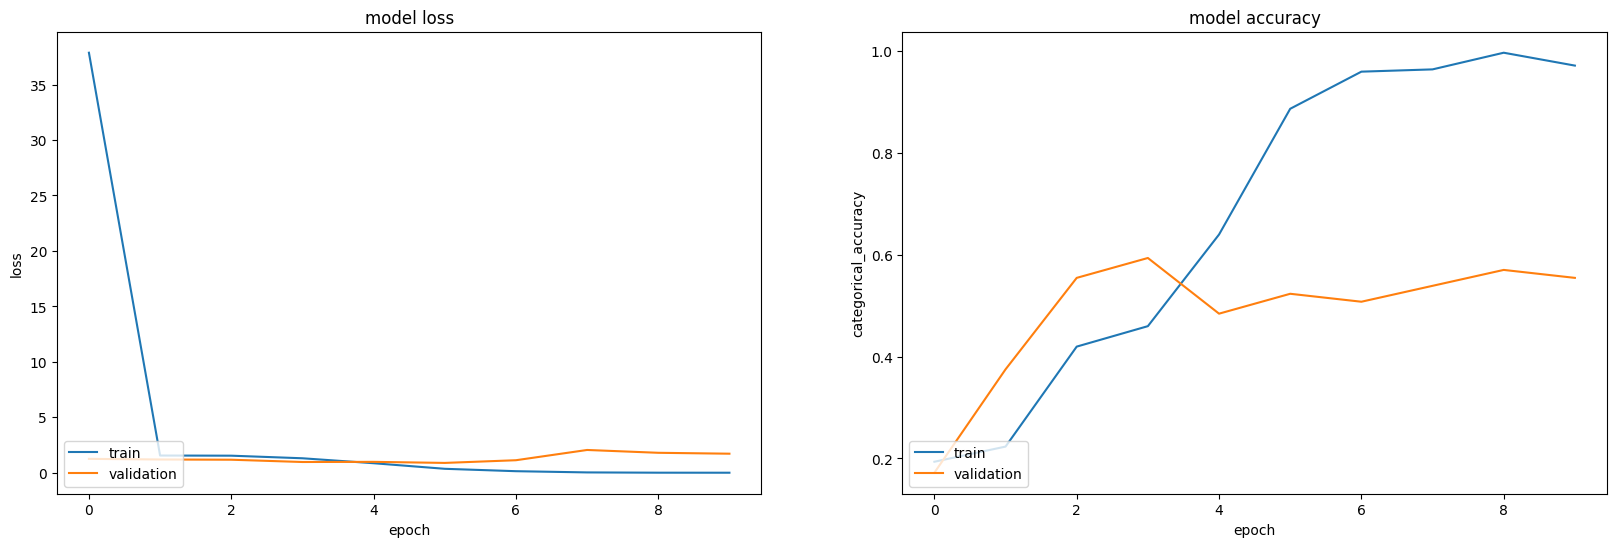

In [ ]:
'''
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
'''

In [ ]:
'''
#4th Model Output
num_epochs = 10 # choose the number of epochs
init_epoch=0
# print optimizer used
print("4th Model Output")
print("Optimizer used is :", optimizer)
print("enable_augmentation :", enable_augmentation)
print("Image_size:", image_size)
tf.config.run_functions_eagerly(True)
# fit the model
history= model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
          callbacks=callbacks_list, validation_data=val_generator,
          validation_steps=validation_steps, class_weight=None, initial_epoch=init_epoch)
'''

4th Model Output
Optimizer used is : <keras.src.optimizers.adam.Adam object at 0x79cbc69de0d0>
enable_augmentation : True
Image_size: (180, 180)
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2133 - loss: 28.1210
Epoch 1: val_loss improved from inf to 1.25699, saving model to model_init4th Model_2025-03-0408_56_43.172580/model-00001-12.33713-0.20387-1.25699-0.16406.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - categorical_accuracy: 0.2129 - loss: 27.4035 - val_categorical_accuracy: 0.1641 - val_loss: 1.2570 - learning_rate: 0.0010
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2032 - loss: 1.6075
Epoch 2: val_loss improved from 1.25699 to 1.25657, saving model to model_init4th Model_2025-03-0408_56_43.172580/model-00002-1.56652-0.20089-1.25657-0.21094.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - categorical_accuracy: 0.2031 - loss: 1.6056 - val_categorical_accuracy: 0.2109 - val_loss: 1.2566 - learning_rate: 0.0010
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2661 - loss: 1.6092
Epoch 3: val_loss improved from 1.25657 to 1.25623, saving model to model_init4th Model_2025-03-0408_56_43.172580/model-00003-1.61035-0.24851-1.25623-0.14844.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - categorical_accuracy: 0.2653 - loss: 1.6092 - val_categorical_accuracy: 0.1484 - val_loss: 1.2562 - learning_rate: 0.0010
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2568 - loss: 1.6048
Epoch 4: val_loss improved from 1.25623 to 1.24712, saving model to model_init4th Model_2025-03-0408_56_43.172580/model-00004-1.56105-0.29315-1.24712-0.21875.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - categorical_accuracy: 0.2585 - loss: 1.6028 - val_categorical_accuracy: 0.2188 - val_loss: 1.2471 - learning_rate: 0.0010
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3105 - loss: 1.5607
Epoch 5: val_loss improved from 1.24712 to 1.10959, saving model to model_init4th Model_2025-03-0408_56_43.172580/model-00005-1.53776-0.31845-1.10959-0.29688.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - categorical_accuracy: 0.3108 - loss: 1.5597 - val_categorical_accuracy: 0.2969 - val_loss: 1.1096 - learning_rate: 0.0010
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5298 - loss: 1.2550
Epoch 6: val_loss improved from 1.10959 to 1.03789, saving model to model_init4th Model_2025-03-0408_56_43.172580/model-00006-1.22505-0.50149-1.03789-0.31250.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - categorical_accuracy: 0.5285 - loss: 1.2536 - val_categorical_accuracy: 0.3125 - val_loss: 1.0379 - learning_rate: 0.0010
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6353 - loss: 0.9551
Epoch 7: val_loss did not improve from 1.03789
21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - categorical_accuracy: 0.6351 - loss: 0.9567 - val_categorical_accuracy: 0.2734 - val_loss: 1.3017 - learning_rate: 0.0010
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7463 - loss: 0.7434
Epoch 8: val_loss did not improve from 1.03789

Epoch 8: ReduceLROnPlateau reducing learning rate to 1e-05.
21/21 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - categorical_accuracy: 0.7451 - loss: 0.7419 - val_categorical_accuracy: 0.3203 - val_loss: 1.1430 - learning_rate: 0.0010
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.8424 - loss: 0.5651
Epoch 9: val_loss did not improve from 1.03789
21/21 ━━━━━━━━━━━━━━━━━━

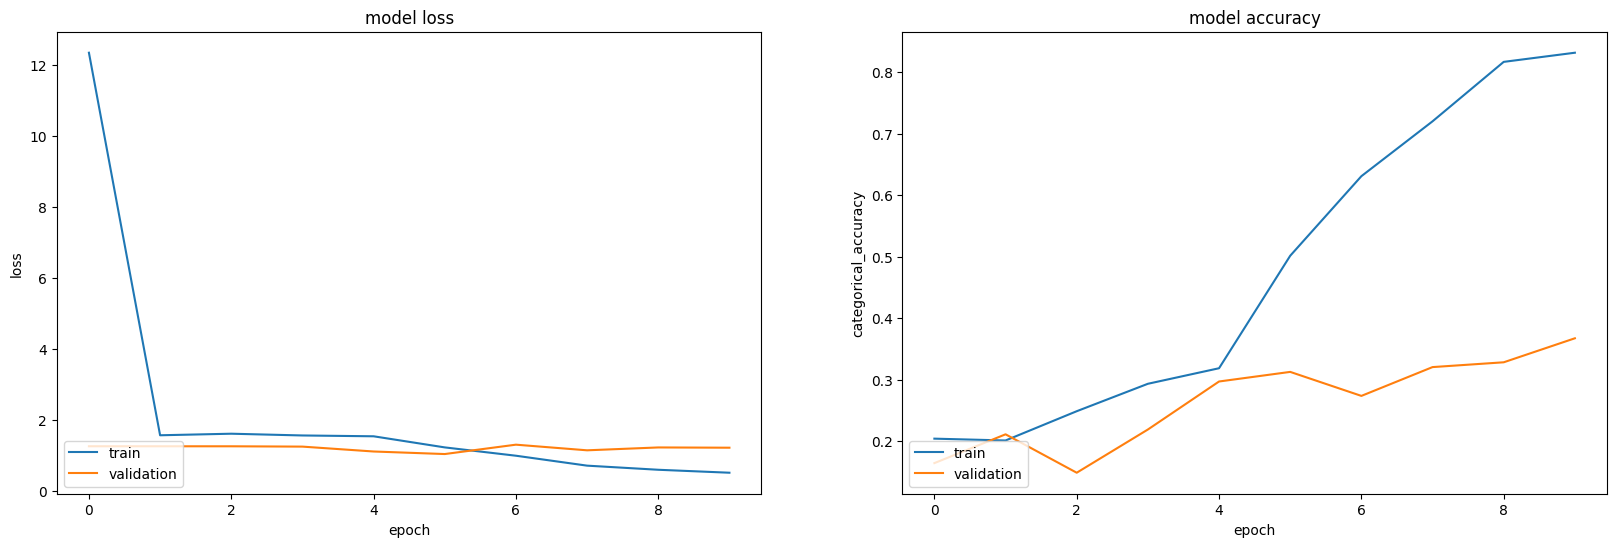

In [ ]:
'''
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
'''

In [ ]:
'''
#5th Model Output
num_epochs = 10 # choose the number of epochs
init_epoch=0
# print optimizer used
print("5th Model Output")
print("Optimizer used is :", optimizer)
print("enable_augmentation :", enable_augmentation)
print("Image_size:", image_size)
# fit the model
history= model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
          callbacks=callbacks_list, validation_data=val_generator,
          validation_steps=validation_steps, class_weight=None, initial_epoch=init_epoch)
'''

5th Model Output
Optimizer used is : <keras.src.optimizers.adam.Adam object at 0x78325ef06810>
enable_augmentation : True
Image_size: (180, 180)
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3806 - loss: 2.2528
Epoch 1: val_loss improved from inf to 2.80059, saving model to model_init5th Model_2025-03-0409_19_28.599612/model-00001-1.98254-0.49851-2.80059-0.25000.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - categorical_accuracy: 0.3859 - loss: 2.2405 - val_categorical_accuracy: 0.2500 - val_loss: 2.8006 - learning_rate: 0.0010
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.8242 - loss: 1.3228
Epoch 2: val_loss improved from 2.80059 to 1.96486, saving model to model_init5th Model_2025-03-0409_19_28.599612/model-00002-1.28772-0.80060-1.96486-0.43750.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - categorical_accuracy: 0.8232 - loss: 1.3212 - val_categorical_accuracy: 0.4375 - val_loss: 1.9649 - learning_rate: 0.0010
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9216 - loss: 1.0793
Epoch 3: val_loss improved from 1.96486 to 1.27822, saving model to model_init5th Model_2025-03-0409_19_28.599612/model-00003-1.02645-0.92857-1.27822-0.52344.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - categorical_accuracy: 0.9219 - loss: 1.0769 - val_categorical_accuracy: 0.5234 - val_loss: 1.2782 - learning_rate: 0.0010
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9705 - loss: 0.8798
Epoch 4: val_loss did not improve from 1.27822
21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - categorical_accuracy: 0.9693 - loss: 0.8784 - val_categorical_accuracy: 0.5312 - val_loss: 1.3166 - learning_rate: 0.0010
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9882 - loss: 0.7522
Epoch 5: val_loss improved from 1.27822 to 1.06159, saving model to model_init5th Model_2025-03-0409_19_28.599612/model-00005-0.73535-0.99107-1.06159-0.82812.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - categorical_accuracy: 0.9883 - loss: 0.7514 - val_categorical_accuracy: 0.8281 - val_loss: 1.0616 - learning_rate: 0.0010
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9931 - loss: 0.6613
Epoch 6: val_loss did not improve from 1.06159
21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - categorical_accuracy: 0.9932 - loss: 0.6604 - val_categorical_accuracy: 0.5703 - val_loss: 1.2288 - learning_rate: 0.0010
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9842 - loss: 0.6679
Epoch 7: val_loss improved from 1.06159 to 1.06097, saving model to model_init5th Model_2025-03-0409_19_28.599612/model-00007-0.65775-0.98512-1.06097-0.61719.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - categorical_accuracy: 0.9843 - loss: 0.6674 - val_categorical_accuracy: 0.6172 - val_loss: 1.0610 - learning_rate: 0.0010
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9965 - loss: 0.5797
Epoch 8: val_loss did not improve from 1.06097
21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - categorical_accuracy: 0.9952 - loss: 0.5793 - val_categorical_accuracy: 0.4844 - val_loss: 1.1950 - learning_rate: 0.0010
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9967 - loss: 0.5373
Epoch 9: val_loss improved from 1.06097 to 0.98089, saving model to model_init5th Model_2025-03-0409_19_28.599612/model-00009-0.52414-0.99702-0.98089-0.82031.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - categorical_accuracy: 0.9967 - loss: 0.5367 - val_categorical_accuracy: 0.8203 - val_loss: 0.9809 - learning_rate: 0.0010
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9999 - loss: 0.4741
Epoch 10: val_loss improved from 0.98089 to 0.80966, saving model to model_init5th Model_2025-03-0409_19_28.599612/model-00010-0.46089-0.99851-0.80966-0.88281.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - categorical_accuracy: 0.9999 - loss: 0.4735 - val_categorical_accuracy: 0.8828 - val_loss: 0.8097 - learning_rate: 0.0010


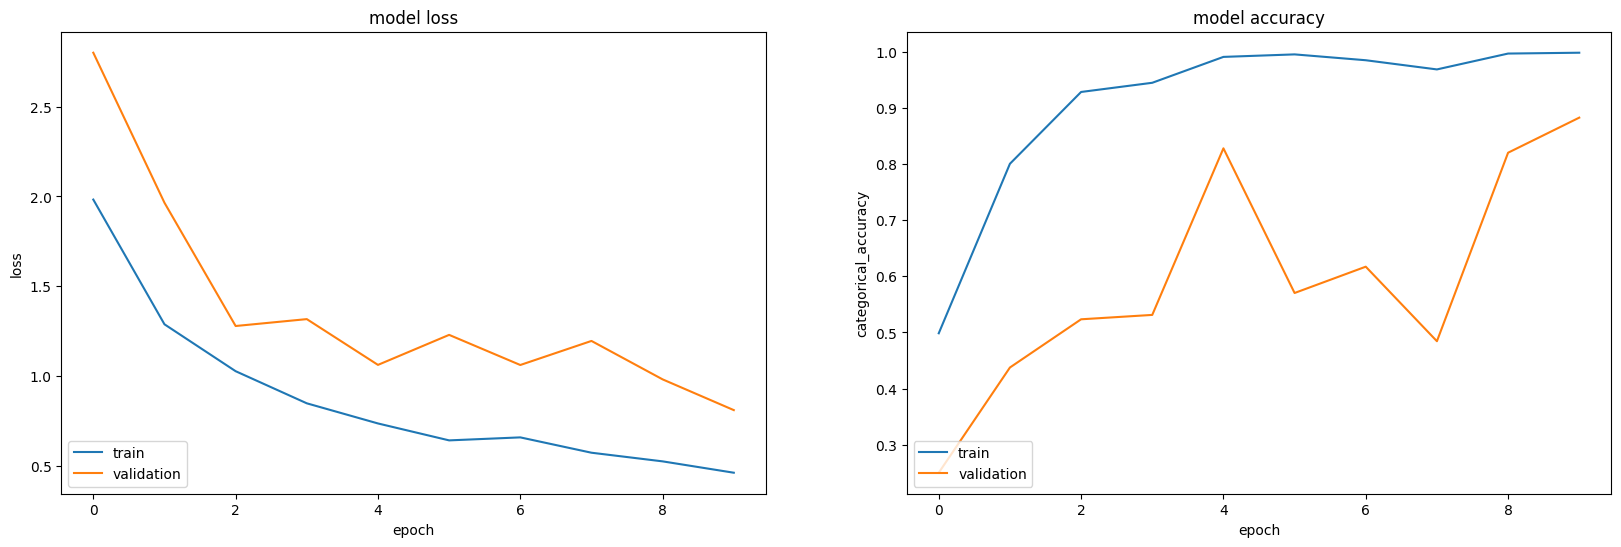

In [ ]:
'''
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
'''

In [ ]:
'''
#6th Model Output
num_epochs = 10 # choose the number of epochs
init_epoch=0
# print optimizer used
print("6th Model Output")
print("Optimizer used is :", optimizer)
print("enable_augmentation :", enable_augmentation)
# fit the model
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
          callbacks=callbacks_list, validation_data=val_generator,
          validation_steps=validation_steps, class_weight=None, initial_epoch=init_epoch)
'''

'\n#6th Model Output\nnum_epochs = 10 # choose the number of epochs\ninit_epoch=0\n# print optimizer used\nprint("6th Model Output")\nprint("Optimizer used is :", optimizer)\nprint("enable_augmentation :", enable_augmentation)\n# fit the model\nhistory=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,\n          callbacks=callbacks_list, validation_data=val_generator,\n          validation_steps=validation_steps, class_weight=None, initial_epoch=init_epoch)\n'

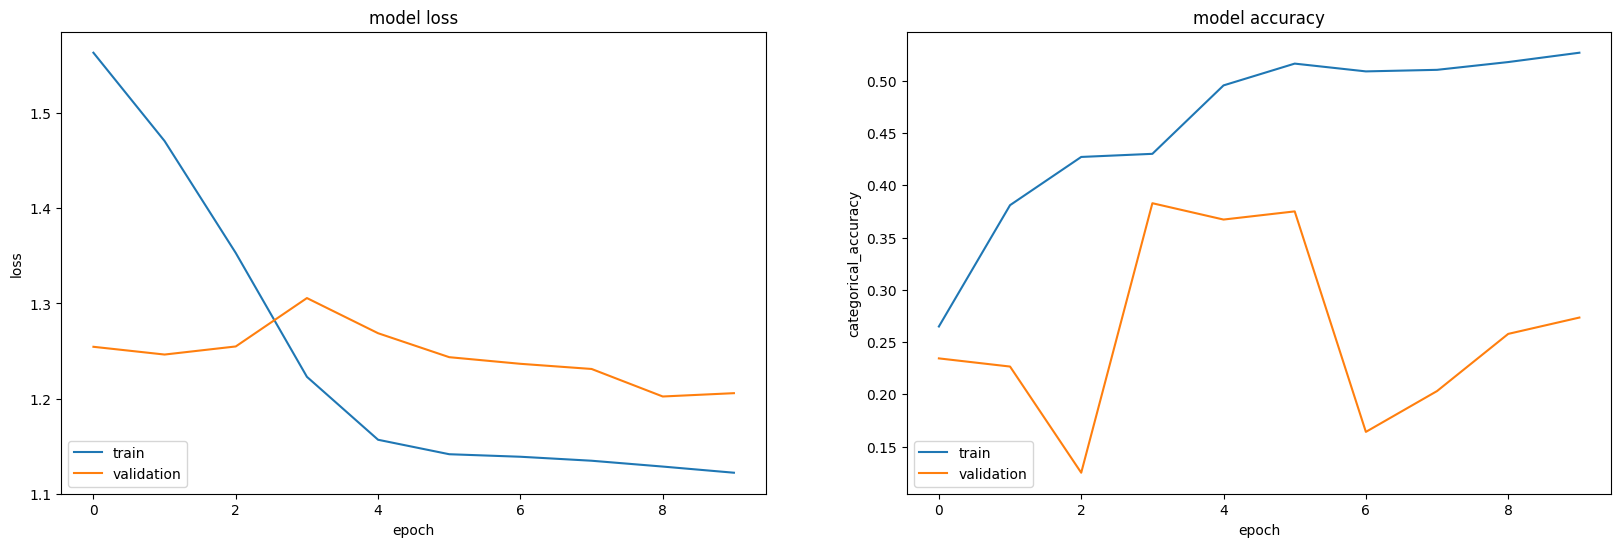

In [ ]:
'''
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
'''

In [21]:

#Final  Model Output
num_epochs = 200 # choose the number of epochs
init_epoch=0
# print optimizer used
print("Final Model Output")
print("Optimizer used is :", optimizer)
print("enable_augmentation :", enable_augmentation)
# fit the model
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
          callbacks=callbacks_final, validation_data=val_generator,
          validation_steps=validation_steps, class_weight=None, initial_epoch=init_epoch)

Final Model Output
Optimizer used is : <keras.src.optimizers.adam.Adam object at 0x7bf3c230b2d0>
enable_augmentation : True
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 166s/step - categorical_accuracy: 0.3737 - loss: 2.1511  
Epoch 1: val_loss improved from inf to 2.03768, saving model to /content/drive/MyDrive/Data-For-Analysis/Gesture-Analysis/File_upload/final_model_2025-03-0504_09_18.130630.kerasmodel-00001-2.08085-0.41667-2.03768-0.16071.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 7872s 192s/step - categorical_accuracy: 0.3747 - loss: 2.1495 - val_categorical_accuracy: 0.1607 - val_loss: 2.0377 - learning_rate: 5.0000e-04
Epoch 2/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5228 - loss: 1.8646
Epoch 2: val_loss improved from 2.03768 to 1.99080, saving model to /content/drive/MyDrive/Data-For-Analysis/Gesture-Analysis/File_upload/final_model_2025-03-0504_09_18.130630.kerasmodel-00002-1.81436-0.51339-1.99080-0.18750.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - categorical_accuracy: 0.5226 - loss: 1.8634 - val_categorical_accuracy: 0.1875 - val_loss: 1.9908 - learning_rate: 4.9997e-04
Epoch 3/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5624 - loss: 1.6528
Epoch 3: val_loss did not improve from 1.99080
42/42 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - categorical_accuracy: 0.5631 - loss: 1.6517 - val_categorical_accuracy: 0.2143 - val_loss: 2.0269 - learning_rate: 4.9988e-04
Epoch 4/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.6669 - loss: 1.4763
Epoch 4: val_loss did not improve from 1.99080
42/42 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - categorical_accuracy: 0.6664 - loss: 1.4757 - val_categorical_accuracy: 0.1786 - val_loss: 2.0510 - learning_rate: 4.9972e-04
Epoch 5/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.6760 - loss: 1.3480
Epoch 5: val_loss did not improve from 1.99080
42/42 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - categorical_accuracy: 0.6764 

42/42 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - categorical_accuracy: 0.8596 - loss: 0.8171 - val_categorical_accuracy: 0.6071 - val_loss: 1.5250 - learning_rate: 4.9628e-04
Epoch 13/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.8629 - loss: 0.8163
Epoch 13: val_loss improved from 1.52497 to 1.18085, saving model to /content/drive/MyDrive/Data-For-Analysis/Gesture-Analysis/File_upload/final_model_2025-03-0504_09_18.130630.kerasmodel-00013-0.83331-0.84821-1.18085-0.67857.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - categorical_accuracy: 0.8626 - loss: 0.8167 - val_categorical_accuracy: 0.6786 - val_loss: 1.1808 - learning_rate: 4.9557e-04
Epoch 14/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.8787 - loss: 0.7518
Epoch 14: val_loss improved from 1.18085 to 0.94463, saving model to /content/drive/MyDrive/Data-For-Analysis/Gesture-Analysis/File_upload/final_model_2025-03-0504_09_18.130630.kerasmodel-00014-0.74289-0.88095-0.94463-0.79464.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - categorical_accuracy: 0.8788 - loss: 0.7516 - val_categorical_accuracy: 0.7946 - val_loss: 0.9446 - learning_rate: 4.9481e-04
Epoch 15/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.8575 - loss: 0.7764
Epoch 15: val_loss improved from 0.94463 to 0.83592, saving model to /content/drive/MyDrive/Data-For-Analysis/Gesture-Analysis/File_upload/final_model_2025-03-0504_09_18.130630.kerasmodel-00015-0.72944-0.88244-0.83592-0.81250.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - categorical_accuracy: 0.8581 - loss: 0.7753 - val_categorical_accuracy: 0.8125 - val_loss: 0.8359 - learning_rate: 4.9398e-04
Epoch 16/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.8676 - loss: 0.7051
Epoch 16: val_loss did not improve from 0.83592
42/42 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - categorical_accuracy: 0.8678 - loss: 0.7049 - val_categorical_accuracy: 0.7768 - val_loss: 1.0015 - learning_rate: 4.9309e-04
Epoch 17/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.8970 - loss: 0.6842
Epoch 17: val_loss did not improve from 0.83592
42/42 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - categorical_accuracy: 0.8968 - loss: 0.6843 - val_categorical_accuracy: 0.8125 - val_loss: 0.8652 - learning_rate: 4.9215e-04
Epoch 18/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.9046 - loss: 0.6254
Epoch 18: val_loss did not improve from 0.83592
42/42 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - categorical_accuracy: 0

42/42 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - categorical_accuracy: 0.8883 - loss: 0.6432 - val_categorical_accuracy: 0.8661 - val_loss: 0.7138 - learning_rate: 4.9007e-04
Epoch 20/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.8921 - loss: 0.6313
Epoch 20: val_loss did not improve from 0.71381
42/42 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - categorical_accuracy: 0.8925 - loss: 0.6309 - val_categorical_accuracy: 0.7857 - val_loss: 0.8404 - learning_rate: 4.8895e-04
Epoch 21/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.9230 - loss: 0.5574
Epoch 21: val_loss did not improve from 0.71381
42/42 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - categorical_accuracy: 0.9227 - loss: 0.5581 - val_categorical_accuracy: 0.8750 - val_loss: 0.7286 - learning_rate: 4.8776e-04
Epoch 22/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.9035 - loss: 0.5718
Epoch 22: val_loss did not improve from 0.71381
42/42 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - categorical_accuracy: 0

42/42 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - categorical_accuracy: 0.9377 - loss: 0.5208 - val_categorical_accuracy: 0.8304 - val_loss: 0.6662 - learning_rate: 4.8522e-04
Epoch 24/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.9256 - loss: 0.5244
Epoch 24: val_loss did not improve from 0.66624
42/42 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - categorical_accuracy: 0.9257 - loss: 0.5242 - val_categorical_accuracy: 0.6696 - val_loss: 1.0864 - learning_rate: 4.8386e-04
Epoch 25/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.9357 - loss: 0.5336
Epoch 25: val_loss did not improve from 0.66624
42/42 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - categorical_accuracy: 0.9353 - loss: 0.5341 - val_categorical_accuracy: 0.7679 - val_loss: 0.6952 - learning_rate: 4.8244e-04
Epoch 26/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.9429 - loss: 0.4880
Epoch 26: val_loss did not improve from 0.66624
42/42 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - categorical_accuracy: 0

42/42 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - categorical_accuracy: 0.9236 - loss: 0.5120 - val_categorical_accuracy: 0.8929 - val_loss: 0.5928 - learning_rate: 4.7944e-04
Epoch 28/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.9271 - loss: 0.5184
Epoch 28: val_loss did not improve from 0.59284
42/42 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - categorical_accuracy: 0.9275 - loss: 0.5174 - val_categorical_accuracy: 0.7054 - val_loss: 0.6697 - learning_rate: 4.7785e-04
Epoch 29/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.9368 - loss: 0.4613
Epoch 29: val_loss did not improve from 0.59284
42/42 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - categorical_accuracy: 0.9366 - loss: 0.4618 - val_categorical_accuracy: 0.6607 - val_loss: 0.7782 - learning_rate: 4.7621e-04
Epoch 30/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.9378 - loss: 0.4422
Epoch 30: val_loss did not improve from 0.59284
42/42 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - categorical_accuracy: 0

42/42 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - categorical_accuracy: 0.9345 - loss: 0.4384 - val_categorical_accuracy: 0.8214 - val_loss: 0.5427 - learning_rate: 4.6716e-04
Epoch 35/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.9491 - loss: 0.3824
Epoch 35: val_loss did not improve from 0.54265
42/42 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - categorical_accuracy: 0.9491 - loss: 0.3826 - val_categorical_accuracy: 0.7321 - val_loss: 0.6244 - learning_rate: 4.6519e-04
Epoch 36/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.9709 - loss: 0.3519
Epoch 36: val_loss improved from 0.54265 to 0.48193, saving model to /content/drive/MyDrive/Data-For-Analysis/Gesture-Analysis/File_upload/final_model_2025-03-0504_09_18.130630.kerasmodel-00036-0.35793-0.97470-0.48193-0.78571.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - categorical_accuracy: 0.9710 - loss: 0.3520 - val_categorical_accuracy: 0.7857 - val_loss: 0.4819 - learning_rate: 4.6316e-04
Epoch 37/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.9390 - loss: 0.4053
Epoch 37: val_loss did not improve from 0.48193
42/42 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - categorical_accuracy: 0.9394 - loss: 0.4044 - val_categorical_accuracy: 0.8036 - val_loss: 0.4923 - learning_rate: 4.6108e-04
Epoch 38/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9329 - loss: 0.4246
Epoch 38: val_loss did not improve from 0.48193
42/42 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - categorical_accuracy: 0.9331 - loss: 0.4243 - val_categorical_accuracy: 0.7232 - val_loss: 0.7016 - learning_rate: 4.5895e-04
Epoch 39/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.9479 - loss: 0.3834
Epoch 39: val_loss did not improve from 0.48193
42/42 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - categorical_accuracy: 0

42/42 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - categorical_accuracy: 0.9559 - loss: 0.3156 - val_categorical_accuracy: 0.8125 - val_loss: 0.4213 - learning_rate: 4.3753e-04
Epoch 48/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.9615 - loss: 0.3215
Epoch 48: val_loss did not improve from 0.42131
42/42 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - categorical_accuracy: 0.9617 - loss: 0.3210 - val_categorical_accuracy: 0.7054 - val_loss: 1.2344 - learning_rate: 4.3491e-04
Epoch 49/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.9438 - loss: 0.3843
Epoch 49: val_loss did not improve from 0.42131
42/42 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - categorical_accuracy: 0.9440 - loss: 0.3833 - val_categorical_accuracy: 0.8571 - val_loss: 0.5882 - learning_rate: 4.3224e-04
Epoch 50/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.9465 - loss: 0.3465
Epoch 50: val_loss did not improve from 0.42131
42/42 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - categorical_accuracy: 0

42/42 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - categorical_accuracy: 0.9572 - loss: 0.2880 - val_categorical_accuracy: 0.9375 - val_loss: 0.4162 - learning_rate: 4.0631e-04
Epoch 59/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.9540 - loss: 0.3048
Epoch 59: val_loss did not improve from 0.41617
42/42 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - categorical_accuracy: 0.9540 - loss: 0.3050 - val_categorical_accuracy: 0.7411 - val_loss: 0.5474 - learning_rate: 4.0323e-04
Epoch 60/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.9635 - loss: 0.2671
Epoch 60: val_loss did not improve from 0.41617
42/42 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - categorical_accuracy: 0.9636 - loss: 0.2669 - val_categorical_accuracy: 0.6964 - val_loss: 0.7630 - learning_rate: 4.0011e-04
Epoch 61/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9701 - loss: 0.2570
Epoch 61: val_loss did not improve from 0.41617
42/42 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - categorical_accuracy: 0

42/42 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - categorical_accuracy: 0.9892 - loss: 0.2289 - val_categorical_accuracy: 0.9196 - val_loss: 0.3665 - learning_rate: 3.9052e-04
Epoch 64/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.9845 - loss: 0.2358
Epoch 64: val_loss did not improve from 0.36646
42/42 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - categorical_accuracy: 0.9845 - loss: 0.2356 - val_categorical_accuracy: 0.8929 - val_loss: 0.3816 - learning_rate: 3.8726e-04
Epoch 65/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.9774 - loss: 0.2432
Epoch 65: val_loss did not improve from 0.36646
42/42 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - categorical_accuracy: 0.9773 - loss: 0.2433 - val_categorical_accuracy: 0.6786 - val_loss: 0.7955 - learning_rate: 3.8396e-04
Epoch 66/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.9765 - loss: 0.2231
Epoch 66: val_loss did not improve from 0.36646
42/42 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - categorical_accuracy: 0

42/42 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - categorical_accuracy: 0.9751 - loss: 0.2357 - val_categorical_accuracy: 0.9018 - val_loss: 0.3312 - learning_rate: 3.5644e-04
Epoch 74/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.9773 - loss: 0.2135
Epoch 74: val_loss did not improve from 0.33121
42/42 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - categorical_accuracy: 0.9774 - loss: 0.2135 - val_categorical_accuracy: 0.8929 - val_loss: 0.3891 - learning_rate: 3.5288e-04
Epoch 75/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.9831 - loss: 0.2299
Epoch 75: val_loss did not improve from 0.33121
42/42 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - categorical_accuracy: 0.9831 - loss: 0.2296 - val_categorical_accuracy: 0.8839 - val_loss: 0.4785 - learning_rate: 3.4929e-04
Epoch 76/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.9726 - loss: 0.2149
Epoch 76: val_loss did not improve from 0.33121
42/42 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - categorical_accuracy: 0

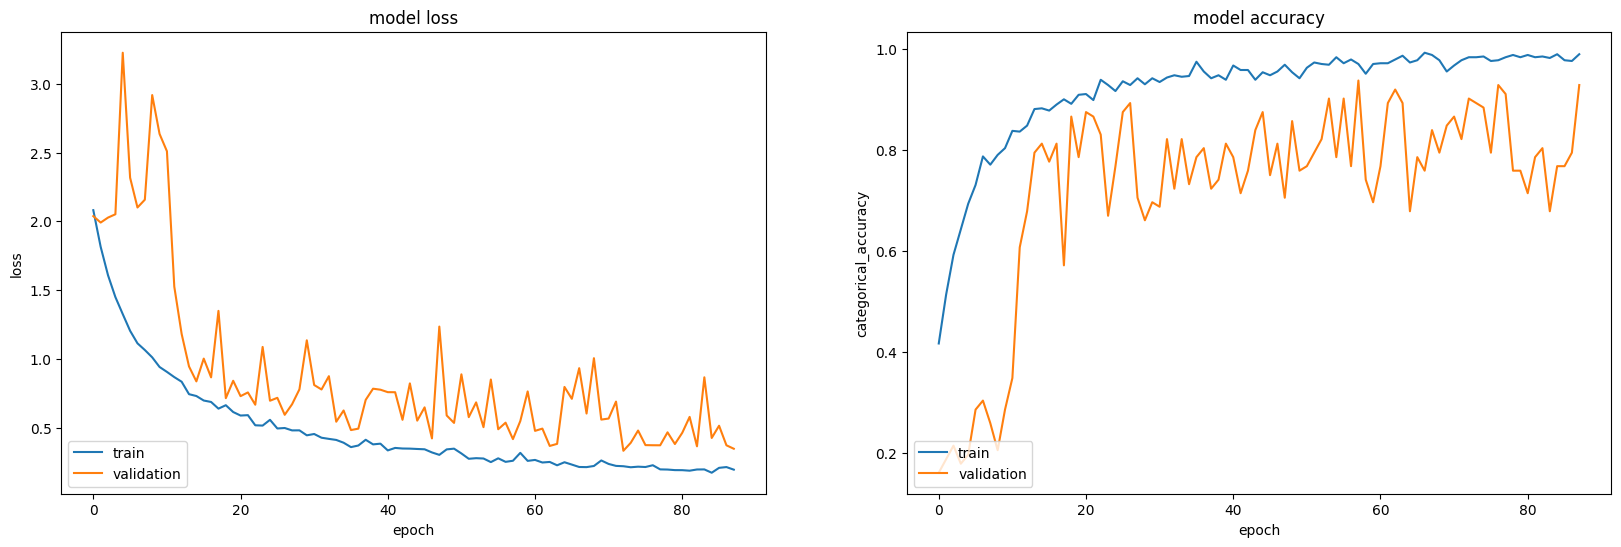

In [22]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

In [ ]:
# write code to force delete the directory starting model_init
import shutil
import os
import glob

def force_delete_model_init_directories(base_path="."):
    """
    Force deletes directories starting with 'model_init' within the specified base path.

    Args:
        base_path (str): The base directory to search in. Defaults to the current directory.
    """
    search_pattern = os.path.join(base_path, "model_init*")
    directories = glob.glob(search_pattern)

    for directory in directories:
        if os.path.isdir(directory):
            try:
                shutil.rmtree(directory)
                print(f"Successfully deleted: {directory}")
            except Exception as e:
                print(f"Error deleting {directory}: {e}")
        else:
            print(f"{directory} is not a directory.")

# Example usage (deletes from the current directory):
#force_delete_model_init_directories()

#If you want to delete from a different directory, provide the path
#force_delete_model_init_directories("/content/your_directory")

Successfully deleted: ./model_init5th Model_2025-03-0408_34_45.396742
Successfully deleted: ./model_init4th Model_2025-03-0405_04_23.649902
Successfully deleted: ./model_init4th Model_2025-03-0408_34_45.396742


In [ ]:
!pip install rarfile


In [ ]:
import rarfile
import os

def compress_to_rar(input_file, output_rar, compression_level=5):
    """
    Compresses a file into a RAR archive.

    Args:
        input_file (str): Path to the input file.
        output_rar (str): Path to the output RAR archive.
        compression_level (int, optional): Compression level (rarfile.RAR_MAX, rarfile.RAR_HIGH, etc.). Defaults to rarfile.RAR_MAX.
    """
    try:
        with rarfile.RarFile(output_rar, 'w', compression=compression_level) as rf:
            rf.write(input_file)
        print(f"File '{input_file}' compressed to '{output_rar}' successfully.")
        return True #success
    except Exception as e:
        print(f"Error compressing file: {e}")
        return False #failure

def get_file_size(filepath):
    """Gets file size in MB"""
    file_size_bytes = os.path.getsize(filepath)
    file_size_mb = file_size_bytes / (1024 * 1024)
    return file_size_mb

def check_rar_size(rar_file, target_size_mb):
    """Checks if the rar file is less than the target size"""
    rar_size = get_file_size(rar_file)
    if rar_size < target_size_mb:
        return True
    else:
        return False

# Example usage:
input_file = "/content/model_init5th Model_2025-03-0409_19_28.599612/model-00010-0.46089-0.99851-0.80966-0.88281.h5"  # Replace with your input file path
output_rar = "/content/drive/MyDrive/Data-For-Analysis/Gesture-Analysis/File_upload/model_init5th_compressed_file.rar"
target_size_mb = 40

if os.path.exists(input_file):
    if compress_to_rar(input_file, output_rar):
        if check_rar_size(output_rar, target_size_mb):
            print(f"The RAR file '{output_rar}' is within the target size ({target_size_mb} MB).")
        else:
            print(f"The RAR file '{output_rar}' is larger than the target size ({target_size_mb} MB).")
else:
    print(f"Error: Input file '{input_file}' does not exist.")


Error compressing file: RarFile.__init__() got an unexpected keyword argument 'compression'
